*Questão 02*

Importando as bibliotecas necessárias

In [63]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Pegando os dados e dividindo em treino e teste aleatoriamente (item A)

In [64]:
data = np.genfromtxt("./california.csv", delimiter=",")
data = np.random.permutation(data) #embaralhando os dados

PERCENT = int(data.shape[0]*0.8) #porcentagem dos dados a ser pegos

#separando os dados de treino9
X_train = data[:PERCENT, :8]
Y_train = data[:PERCENT, 8].reshape(-1,1)

#separando os dados de teste
X_test = data[PERCENT:, :8]
Y_test = data[PERCENT:, 8].reshape(-1,1)

Implementando a função de transformação não linear

In [65]:
def nonLinearTrans(data, order):
    aux = data.copy()
    for i in range (2,order+1):
        power = data**i
        aux = np.concatenate((aux, power), axis = 1)
    return aux

Implementando a função de normaliação minMax

In [66]:
def minMax(data):
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    
    denom = max_vals - min_vals

    return [min_vals, max_vals,(data - min_vals) / denom]

def standard(data):
    means = data.mean(0)
    stds = np.sqrt((np.sum((data - means)**2,axis=0))/(data.shape[0] - 1))
    return [means, stds, (data - means)/stds]

def standardRev(data, means, stds): #função inversa da normalização standard
    return data*stds + means

Treinando os modelos de regressão polinomial de ordens 1 a 13 (item B)

In [67]:
# Listas para guardar os pesos, os RMSEs e os resultados
W_list = []
rmse_list = []
Y_list = []

#listas de valores mínimos e máximos para normalização das features de teste
max_list = [0]*13
min_list = [0]*13

#normalizando a saída por z-escore
[means, stds, Y_train_norm] = standard(Y_train)

for order in range(1, 14):
    X_poly = X_train.copy() #resetando as features 
    X_poly = nonLinearTrans(X_poly, order)  # Aplicando transformação polinomial
    [min_list[order-1], max_list[order-1], X_poly] = minMax(X_poly)  # Normalizando os dados de entrada
    
    # Adicionando uma coluna de 1 nas features
    X_poly = np.concatenate((np.ones((X_poly.shape[0], 1)), X_poly), axis=1)

    # Calculando os pesos usando OLS (sem regularização)
    W = np.linalg.solve(X_poly.T @ X_poly, X_poly.T @ Y_train_norm)

    # Fazendo as predições
    Y_pred = X_poly @ W

    # desnormalizando para calcular RMSE na escala original
    Y_pred_desnorm = standardRev(Y_pred, means, stds)

    # Calculando o RMSE de treino
    rmse = np.sqrt(np.mean((Y_train - Y_pred_desnorm) ** 2))

    # Armazena resultados
    W_list.append(W)
    rmse_list.append(rmse)
    Y_list.append(Y_pred_desnorm)


Plotando os gráficos de treino e teste para cada modelo (item c)

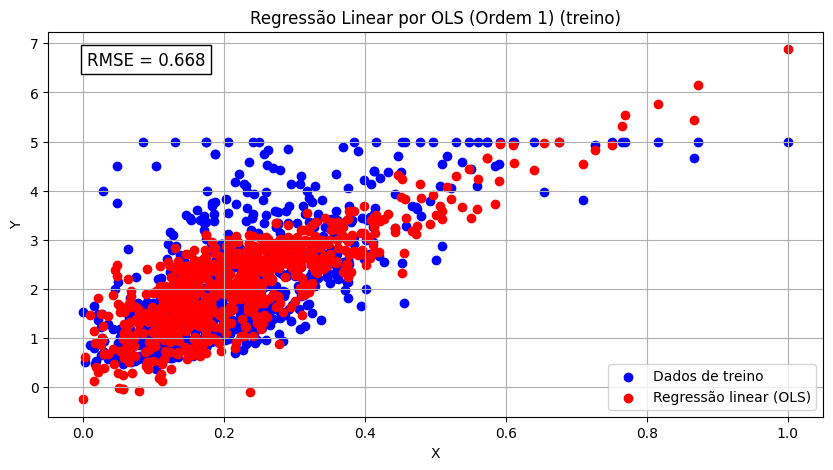

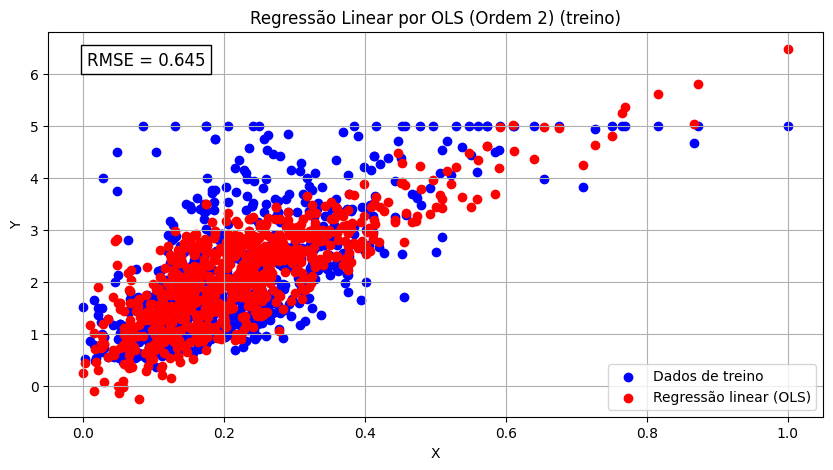

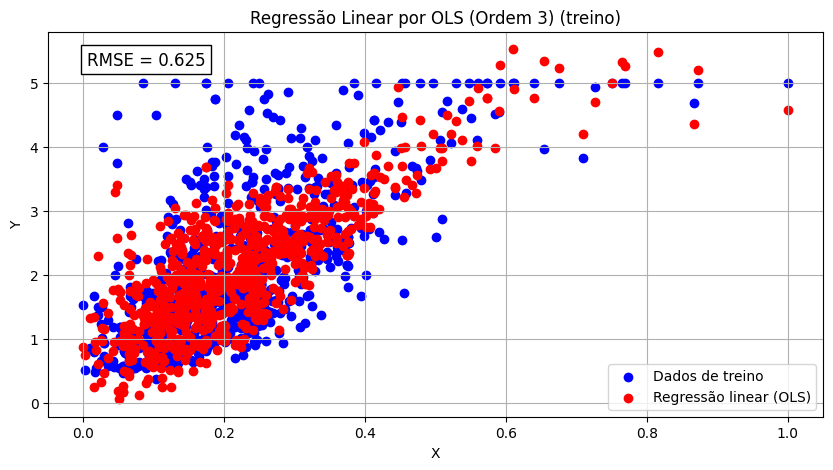

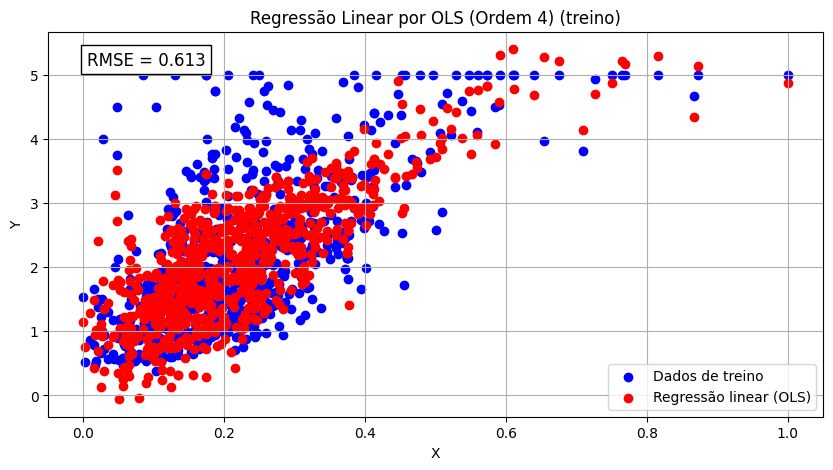

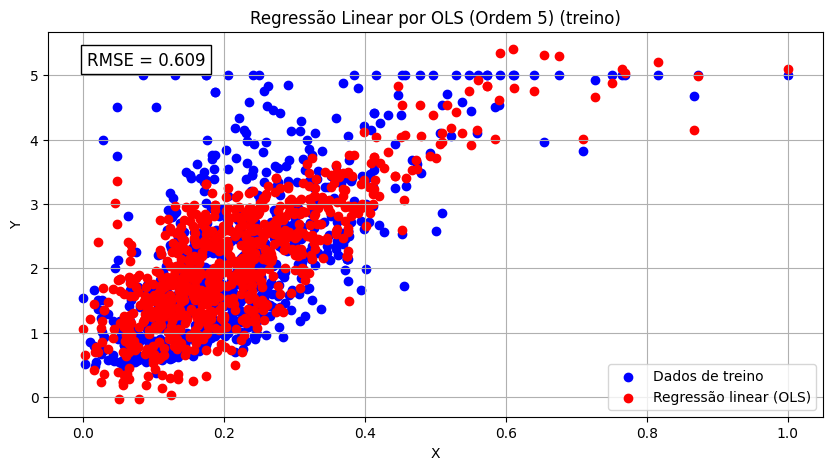

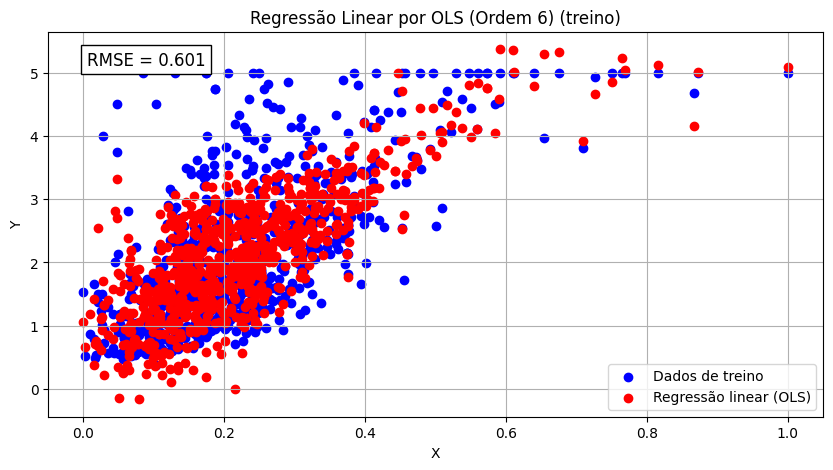

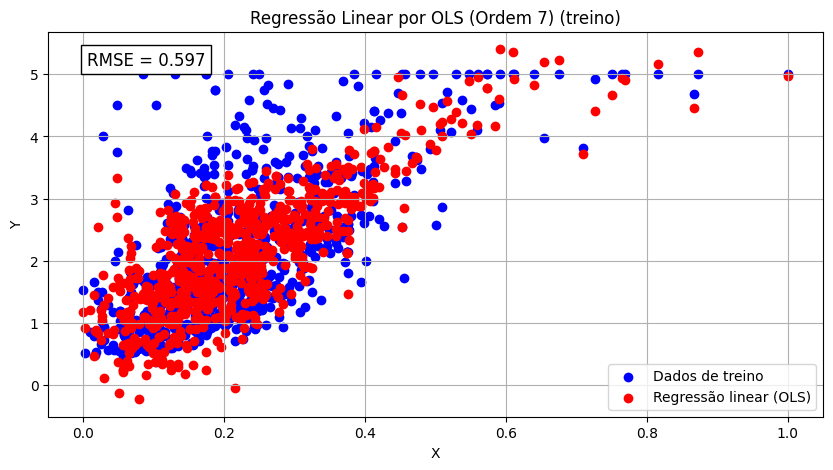

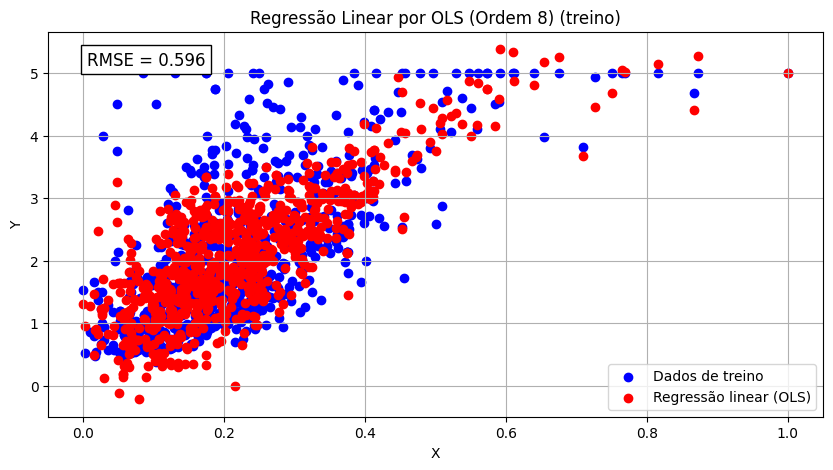

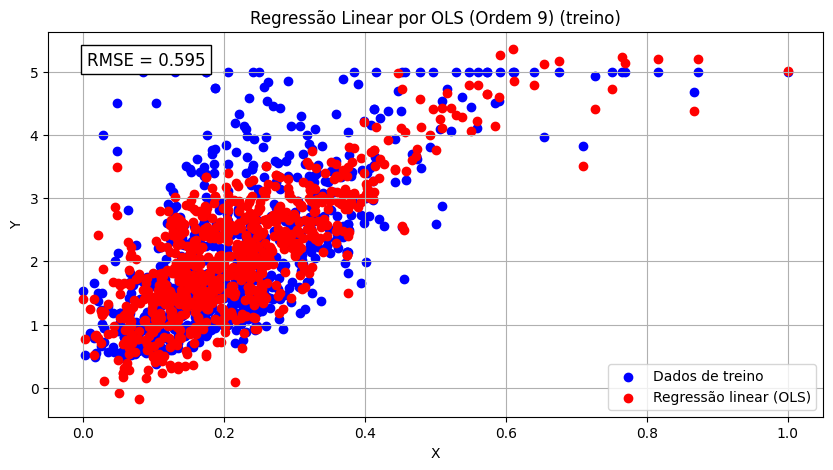

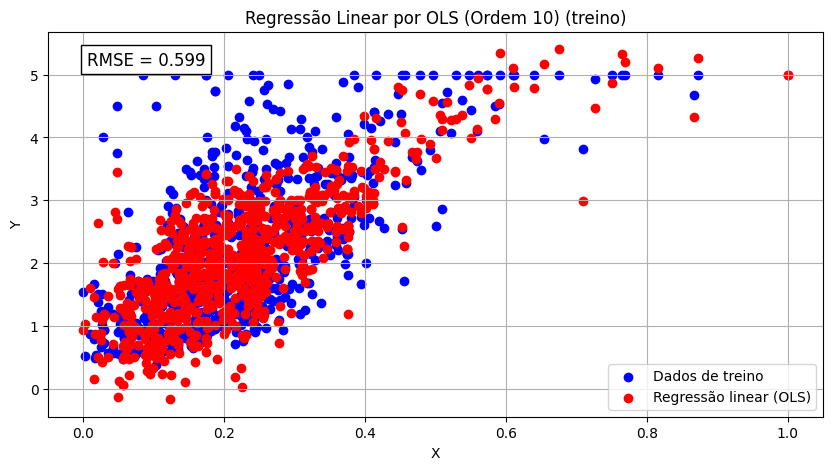

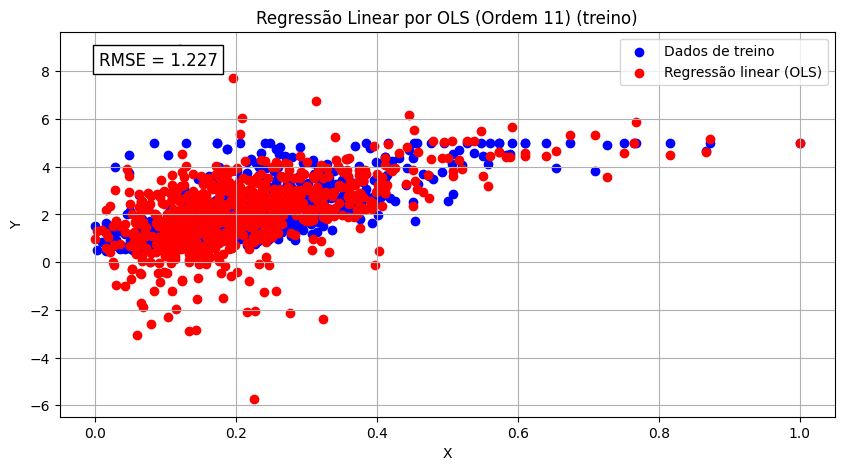

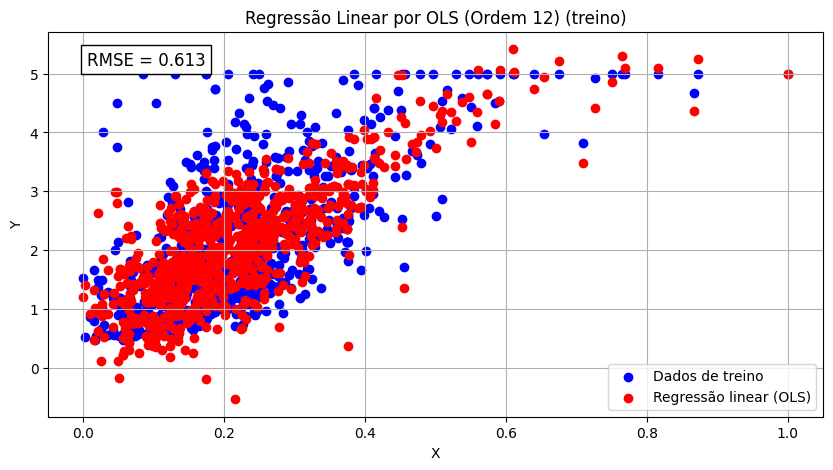

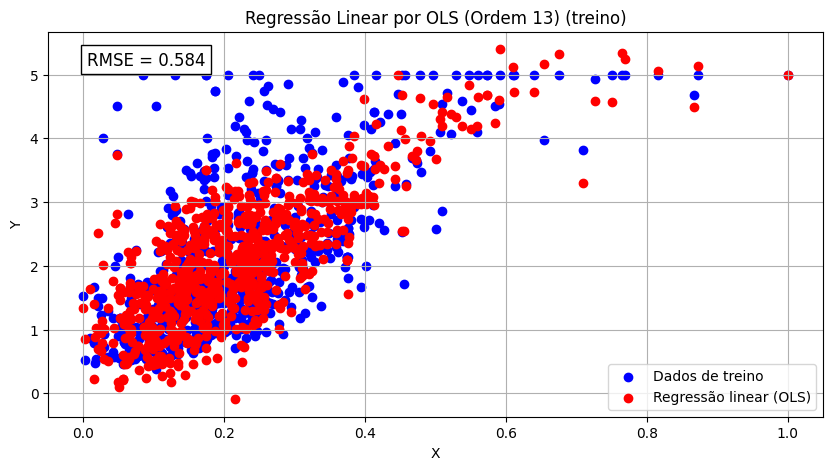

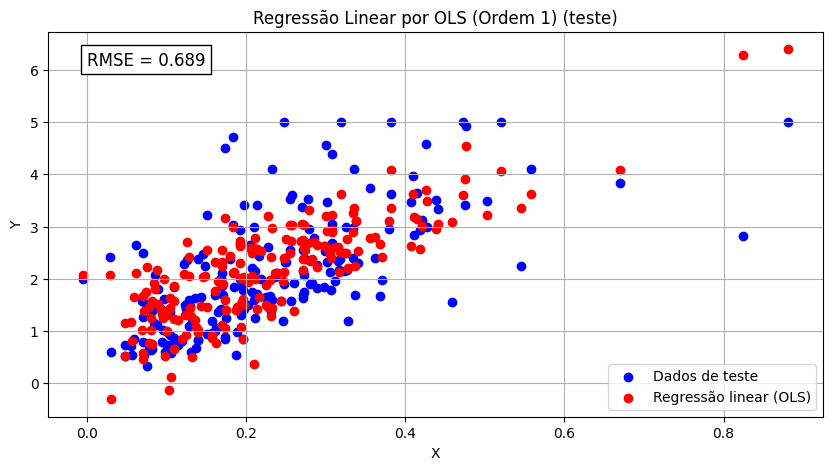

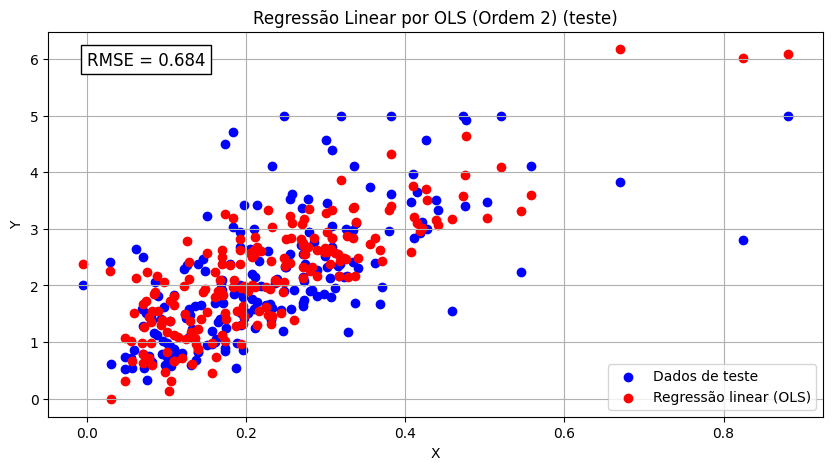

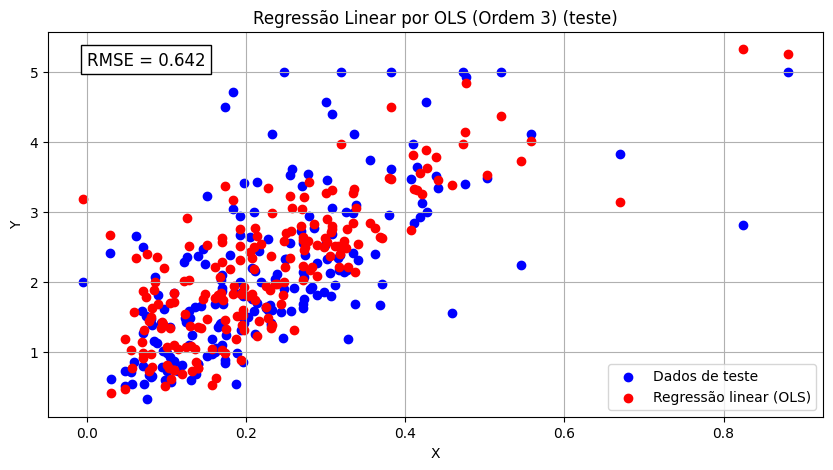

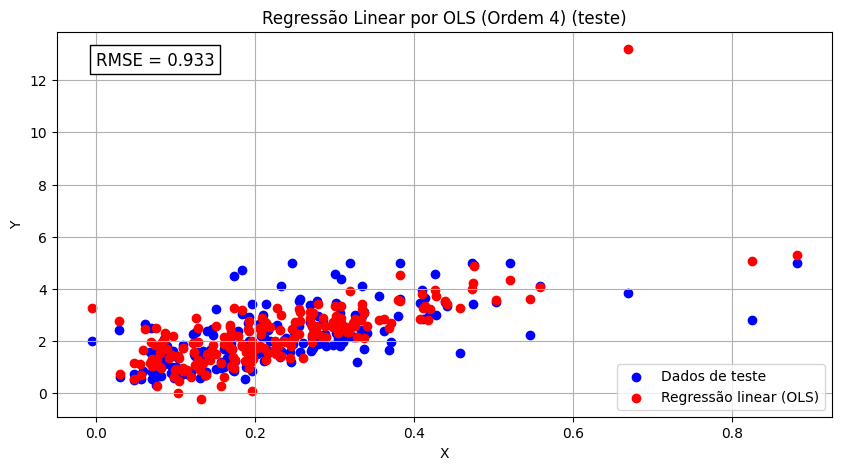

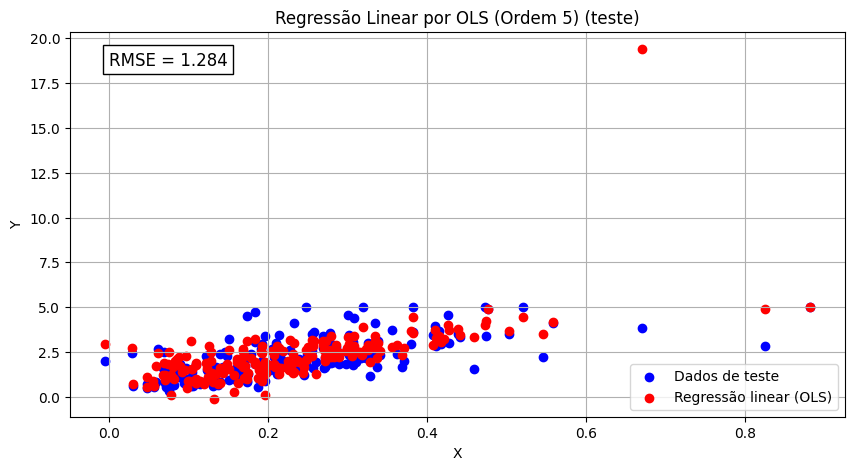

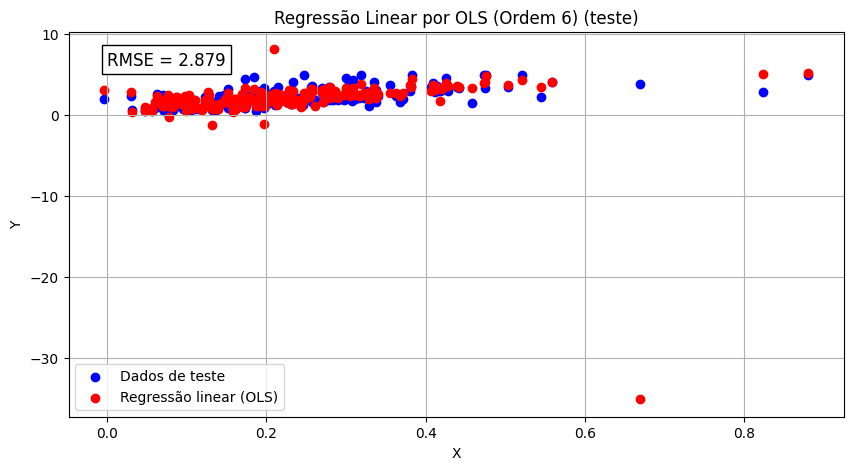

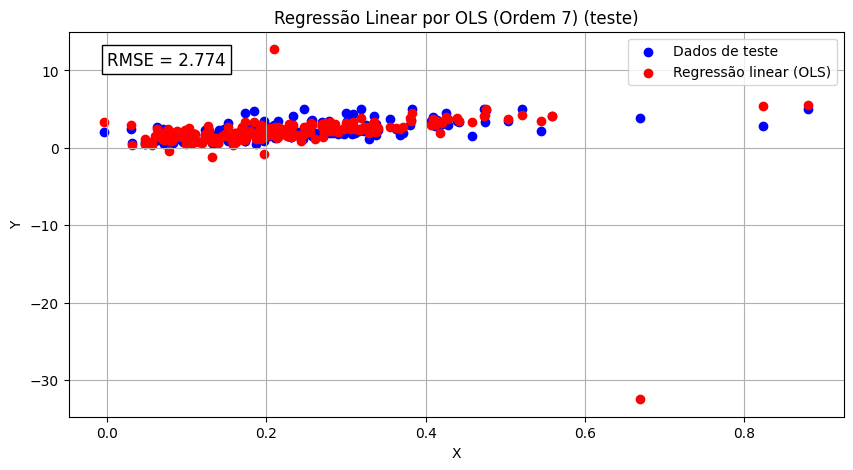

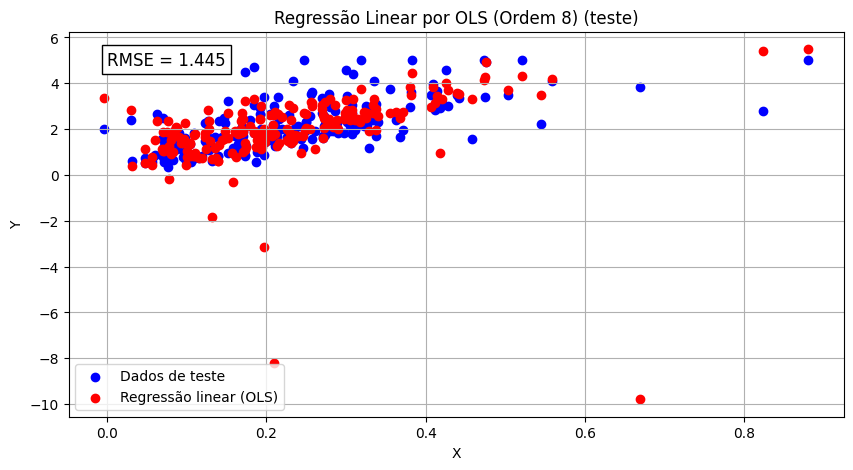

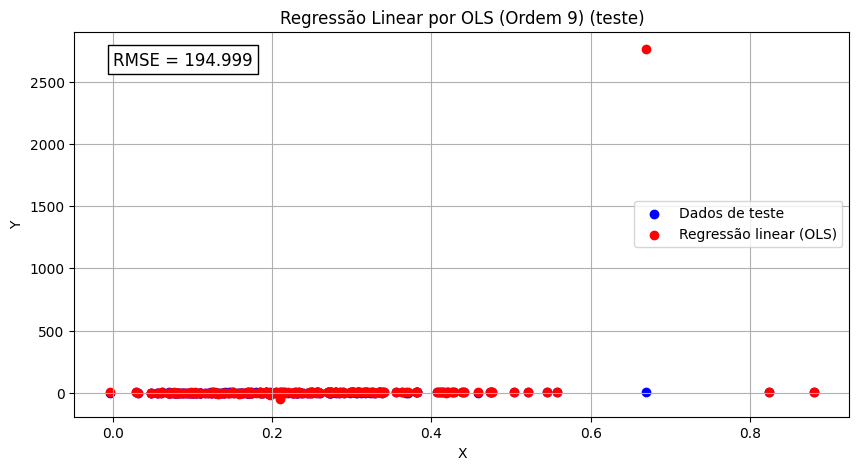

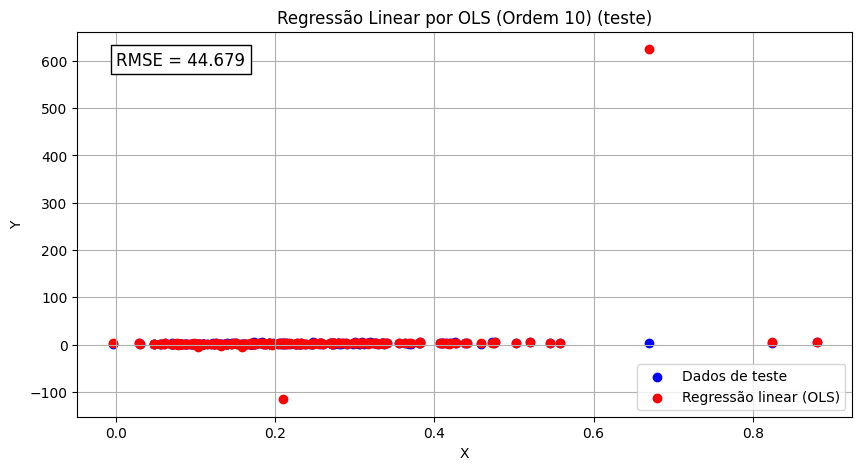

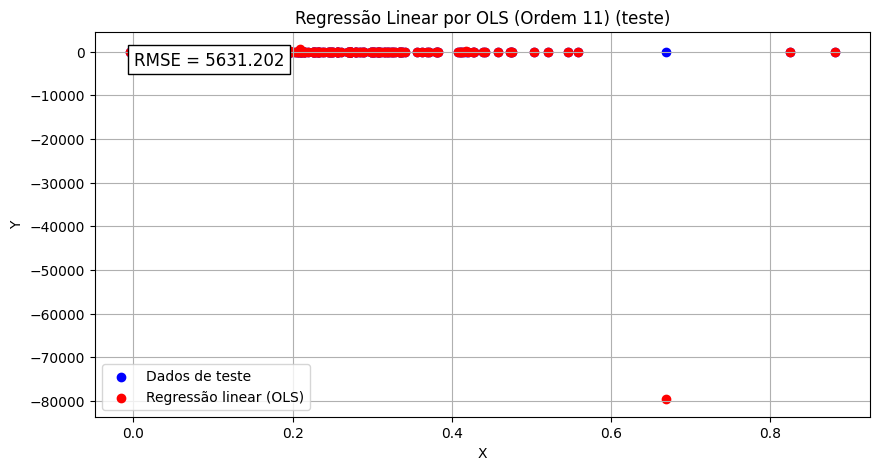

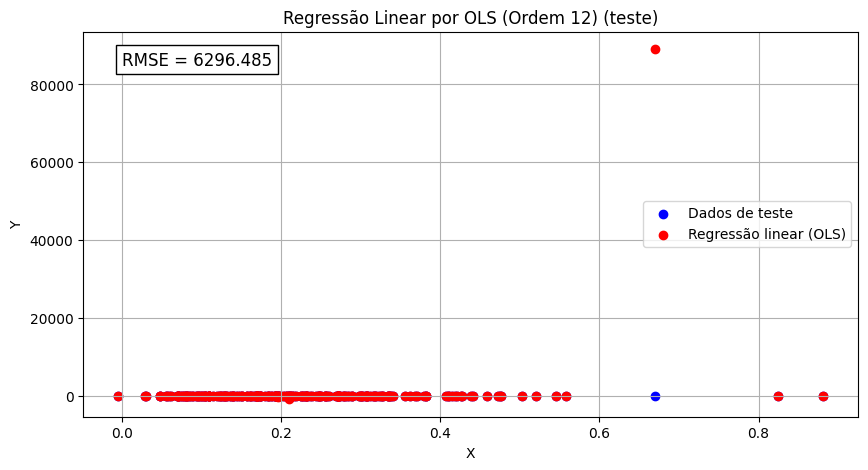

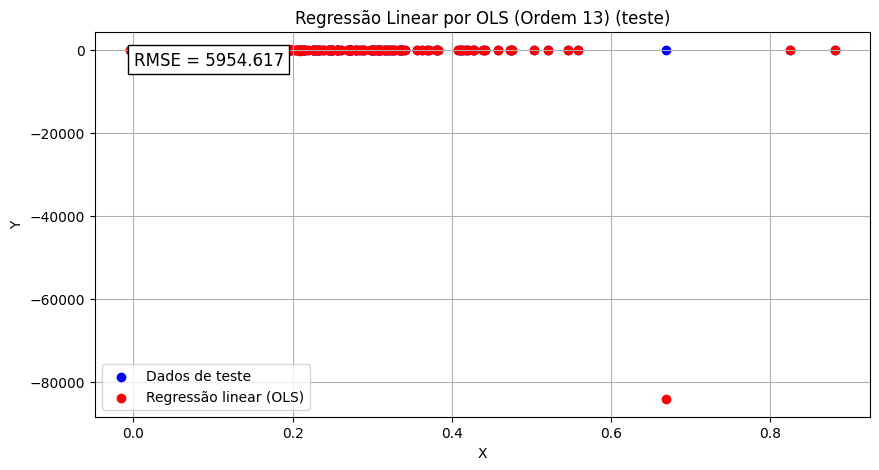

In [68]:
#Gráficos dos dados de treino
for i in range(order):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_poly[:, 1], Y_train, color='blue', label='Dados de treino')
    plt.scatter(X_poly[:, 1], Y_list[i], color='red', label='Regressão linear (OLS)')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Regressão Linear por OLS (Ordem {i+1}) (treino)")
    plt.text(0.05, 0.95, f"RMSE = {rmse_list[i]:.3f}", transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    plt.grid(True)
    plt.legend()
    plt.show()

#gráficos dos dados de teste
for i in range(order):
    X_poly_test = X_test.copy()
    X_poly_test = nonLinearTrans(X_poly_test, i+1) #aplicando a tranformação polinomial
    X_poly_test = (X_poly_test - min_list[i])/(max_list[i] - min_list[i]) #normalizando na mesma escala de treino
    X_poly_test = np.concatenate((np.ones((X_poly_test.shape[0], 1)), X_poly_test), axis=1)

    Y_test_pred = X_poly_test @ W_list[i]
    Y_test_pred = standardRev(Y_test_pred, means, stds) #desnormalizando para calcular o RMSE na mesma escala
    rmse = np.sqrt(np.mean((Y_test - Y_test_pred) ** 2))

    plt.figure(figsize=(10, 5))
    plt.scatter(X_poly_test[:, 1], Y_test, color='blue', label='Dados de teste')
    plt.scatter(X_poly_test[:, 1], Y_test_pred, color='red', label='Regressão linear (OLS)')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Regressão Linear por OLS (Ordem {i+1}) (teste)")
    plt.text(0.05, 0.95, f"RMSE = {rmse:.3f}", transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    plt.grid(True)
    plt.legend()
    plt.show()

Refazendo os modelos com regularização L2 (item D)

In [69]:
# Listas para guardar os pesos, os RMSEs e os resultados
W_list = []
rmse_list = []
Y_list = []

#listas de valores mínimos e máximos para normalização das features de teste
max_list = [0]*13
min_list = [0]*13

#normalizando a saída por z-escore
[means, stds, Y_train_norm] = standard(Y_train)

LAMBDA = 0.009

for order in range(1, 14):
    X_poly = X_train.copy() #resetando as features 
    X_poly = nonLinearTrans(X_poly, order)  # Aplicando transformação polinomial
    [min_list[order-1], max_list[order-1], X_poly] = minMax(X_poly)  # Normalizando os dados de entrada
    
    # Adicionando uma coluna de 1 nas features
    X_poly = np.concatenate((np.ones((X_poly.shape[0], 1)), X_poly), axis=1)

    #Criando a matriz identidade modificada: 0 na posição (0,0) para não regularizar o bias
    I = np.eye(X_poly.shape[1])
    I[0, 0] = 0

    # Calculando os pesos usando OLS (sem regularização)
    W = np.linalg.solve(X_poly.T @ X_poly + LAMBDA * I, X_poly.T @ Y_train_norm)

    # Fazendo as predições
    Y_pred = X_poly @ W

    # desnormalizando para calcular RMSE na escala original
    Y_pred_desnorm = standardRev(Y_pred, means, stds)

    # Calculando o RMSE de treino
    rmse = np.sqrt(np.mean((Y_train - Y_pred_desnorm) ** 2))

    # Armazena resultados
    W_list.append(W)
    rmse_list.append(rmse)
    Y_list.append(Y_pred_desnorm)

Plotando os gráficos com regularização L2

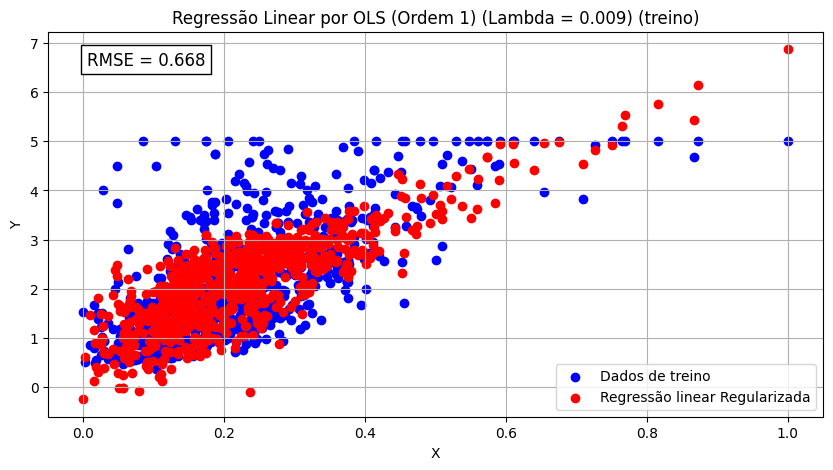

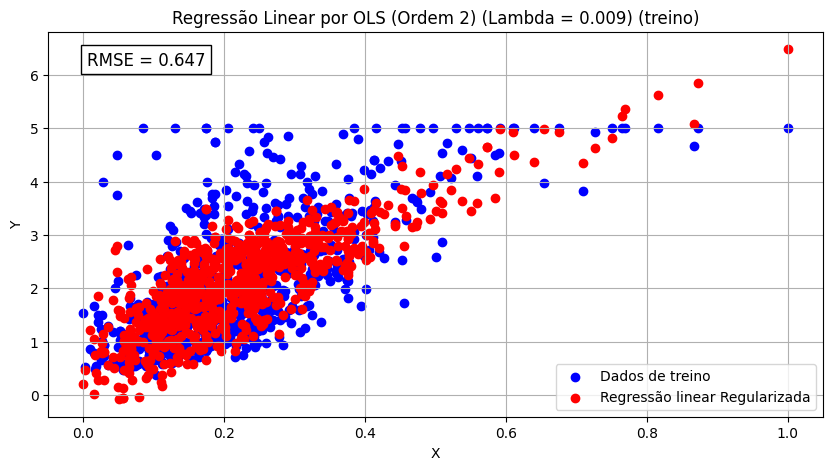

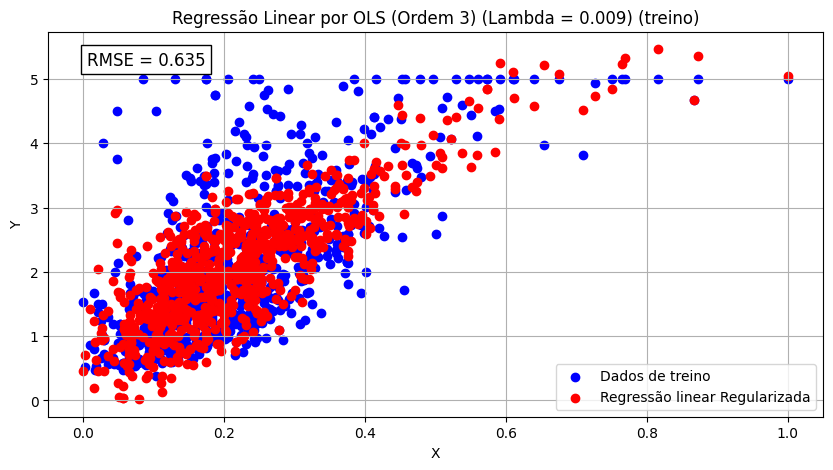

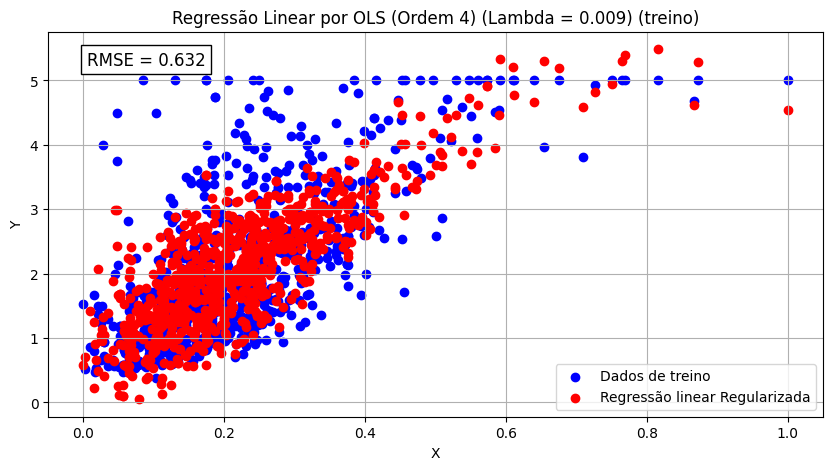

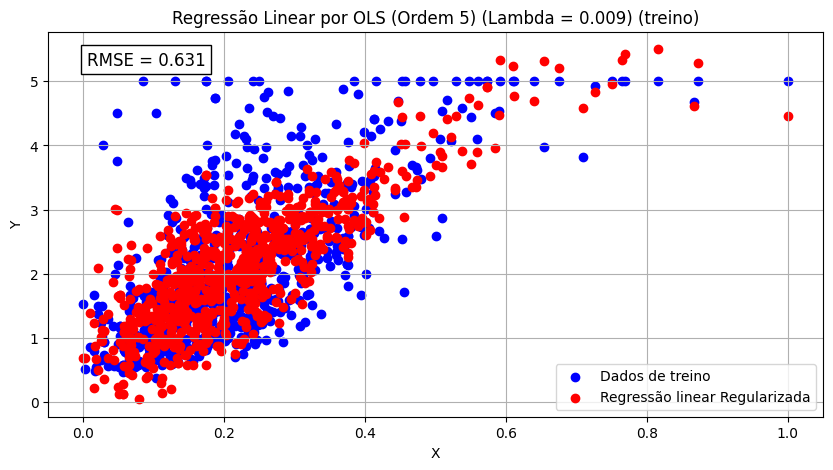

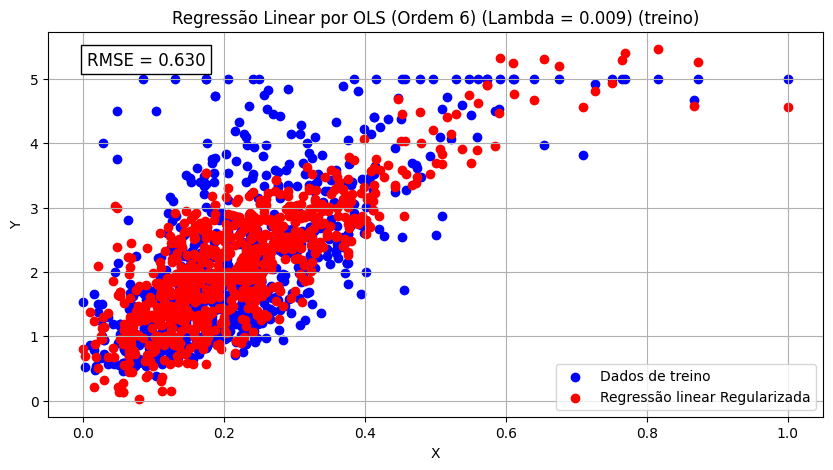

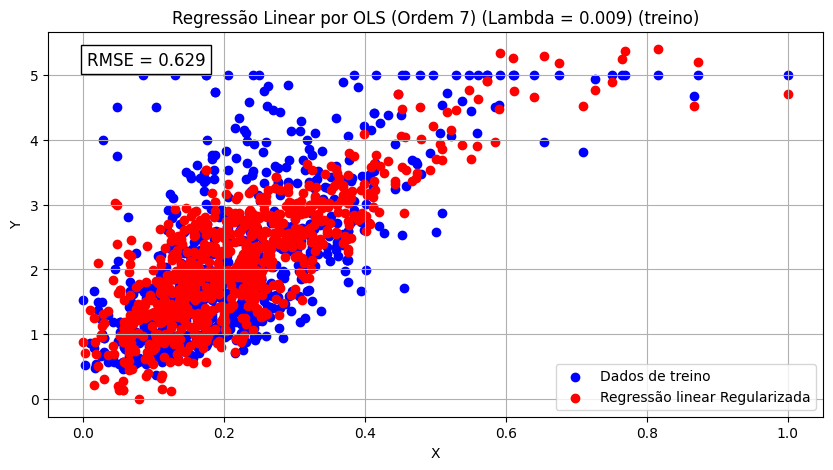

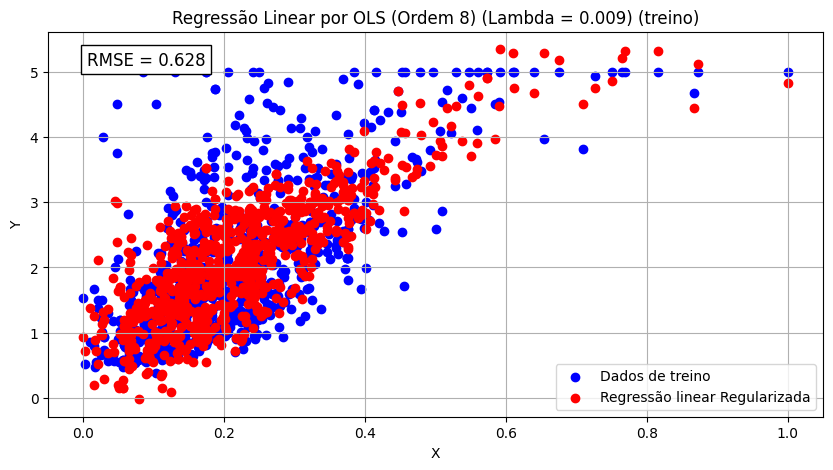

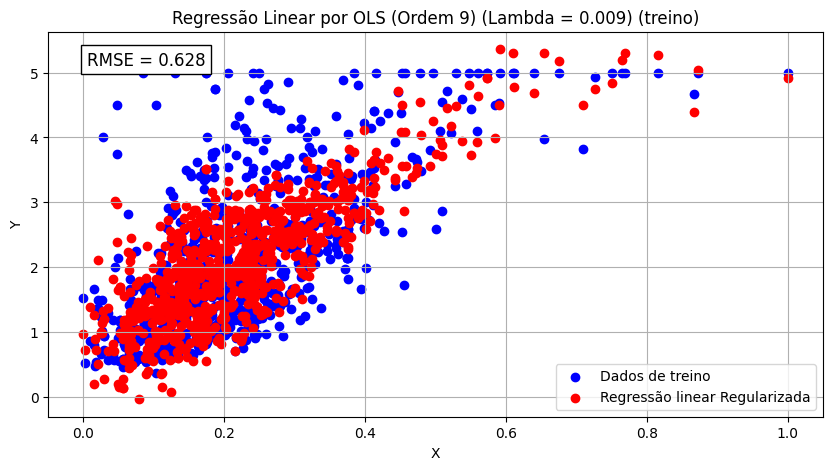

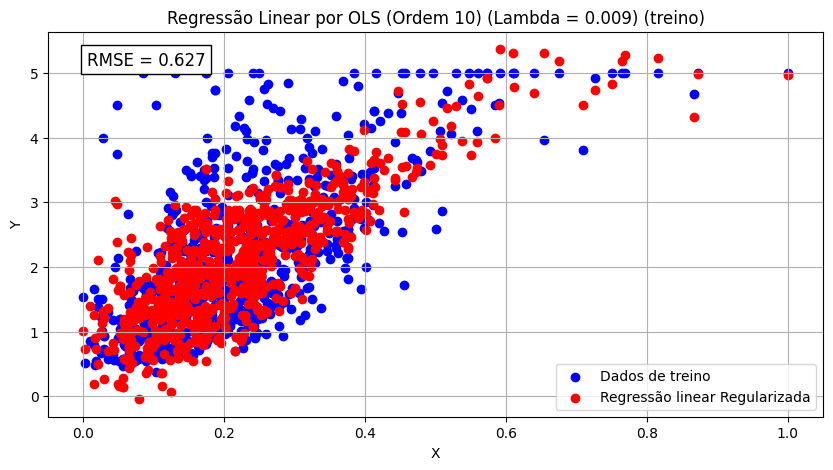

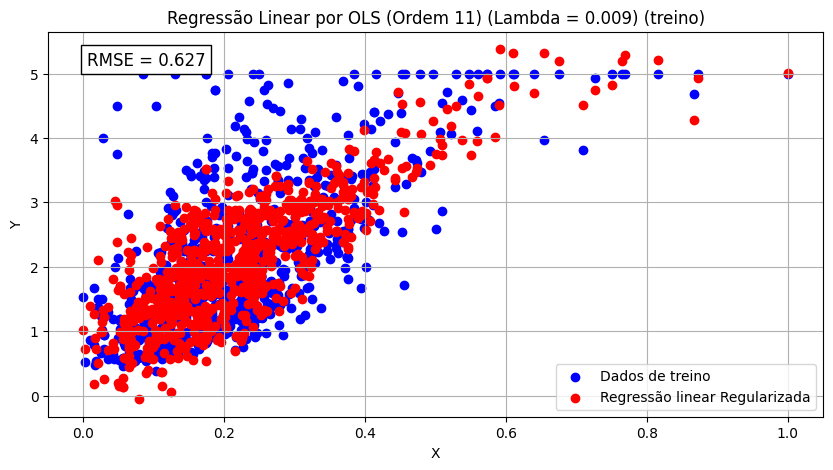

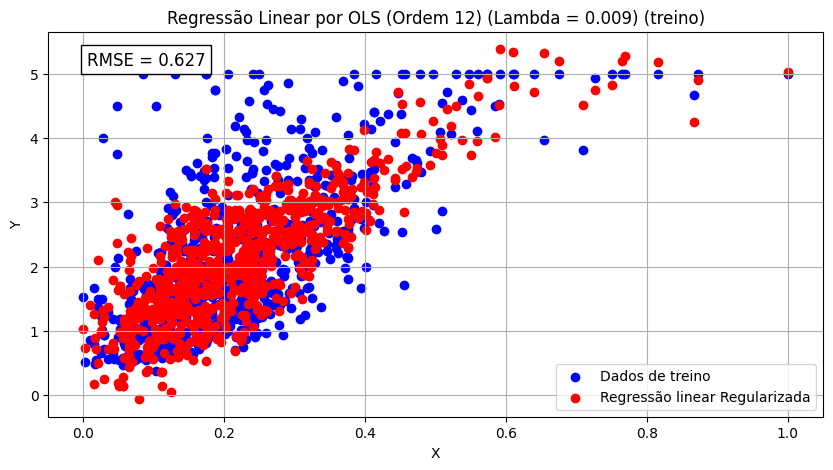

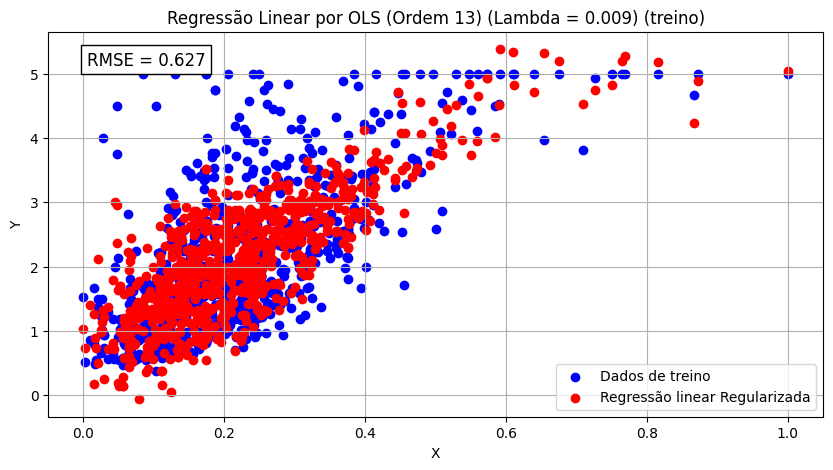

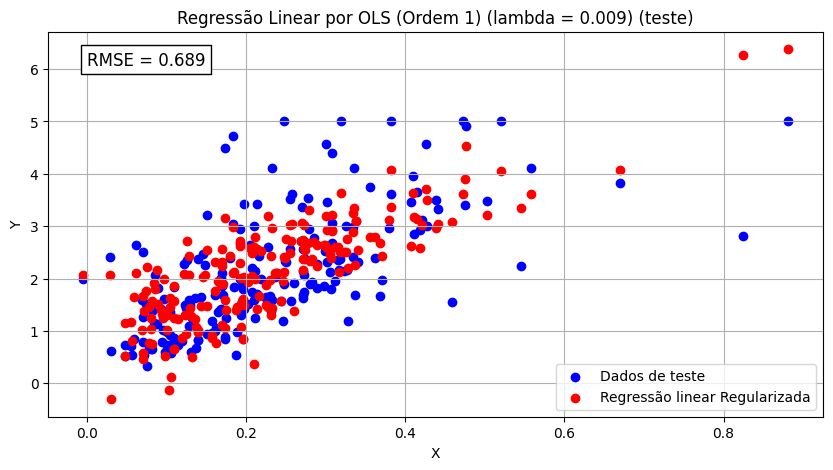

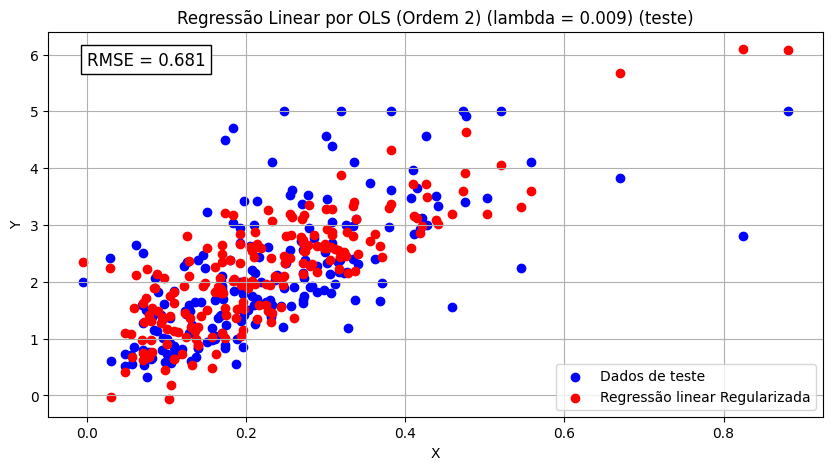

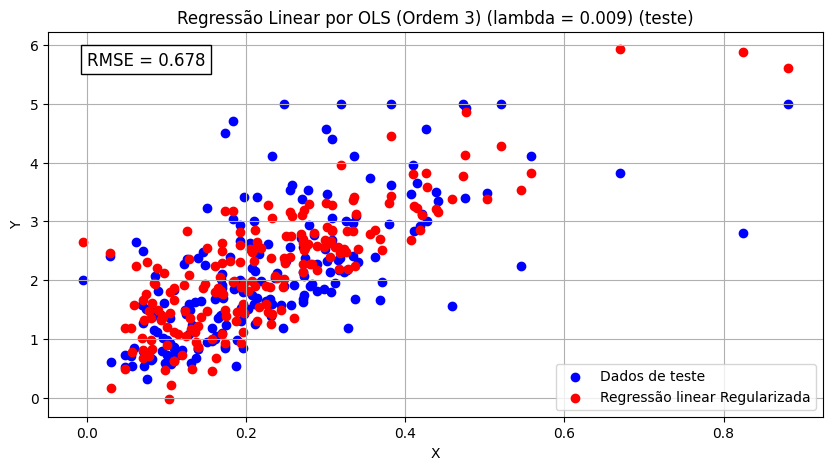

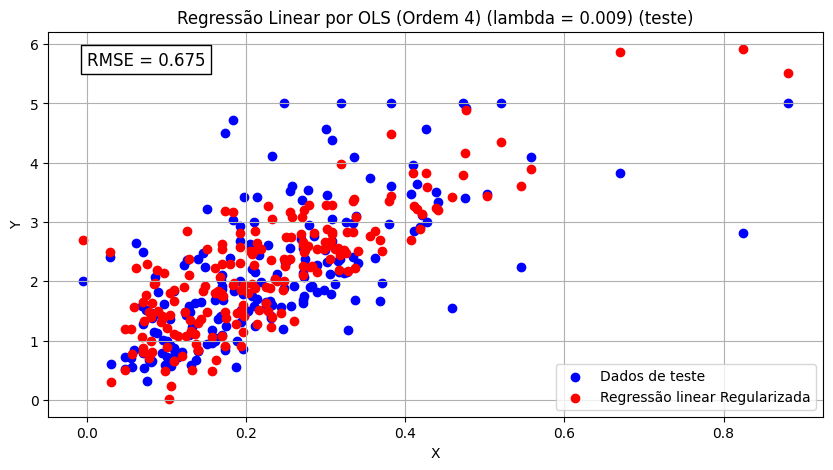

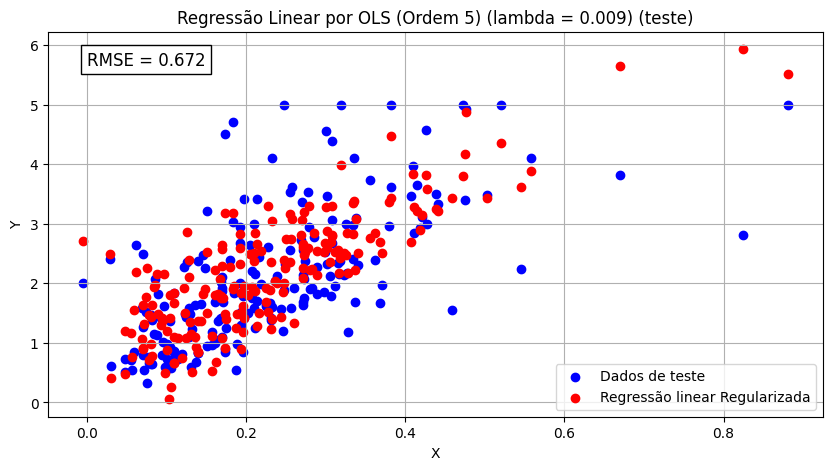

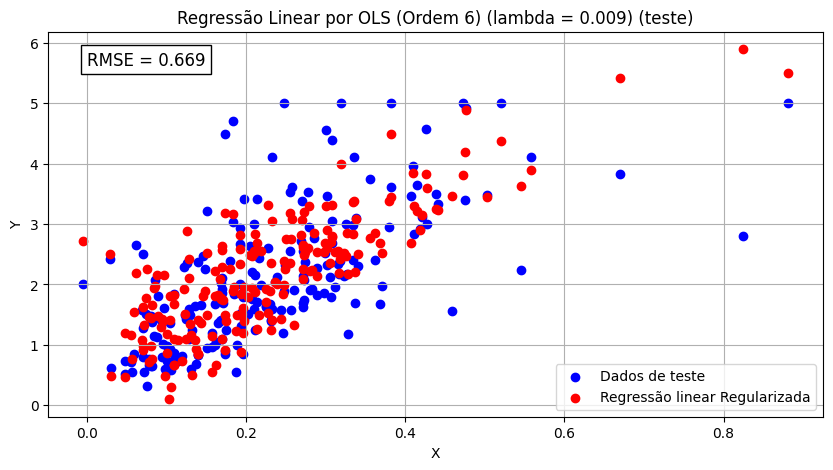

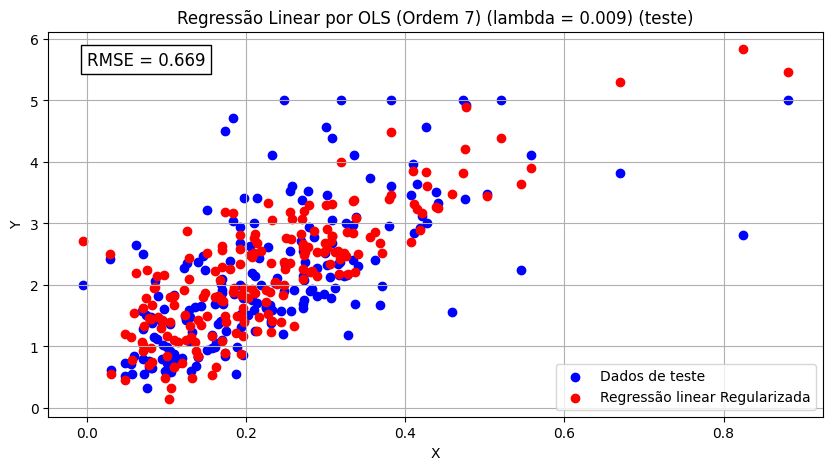

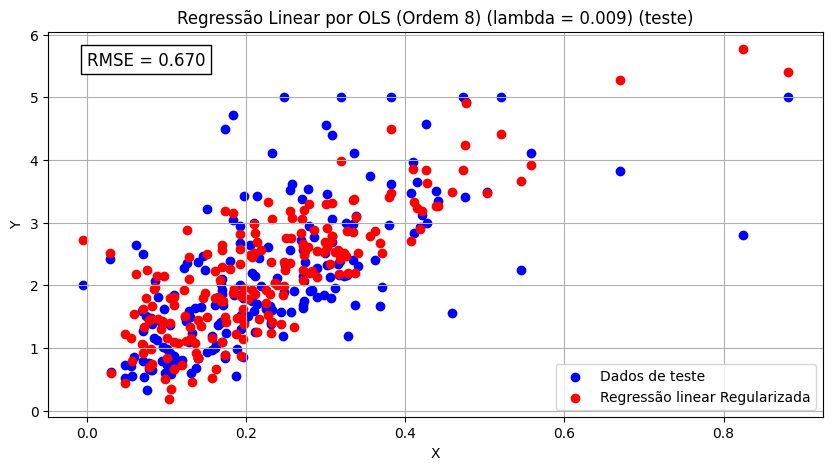

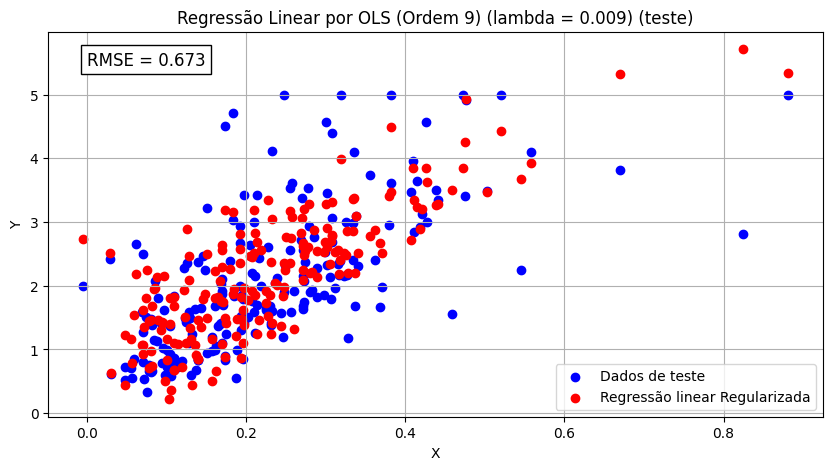

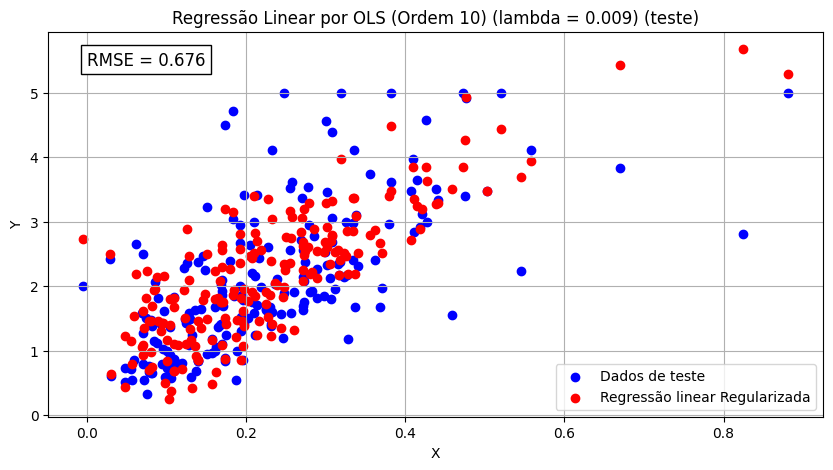

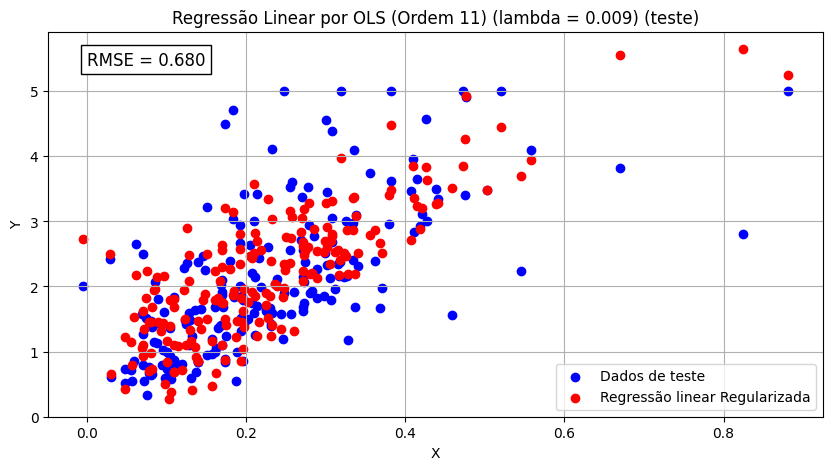

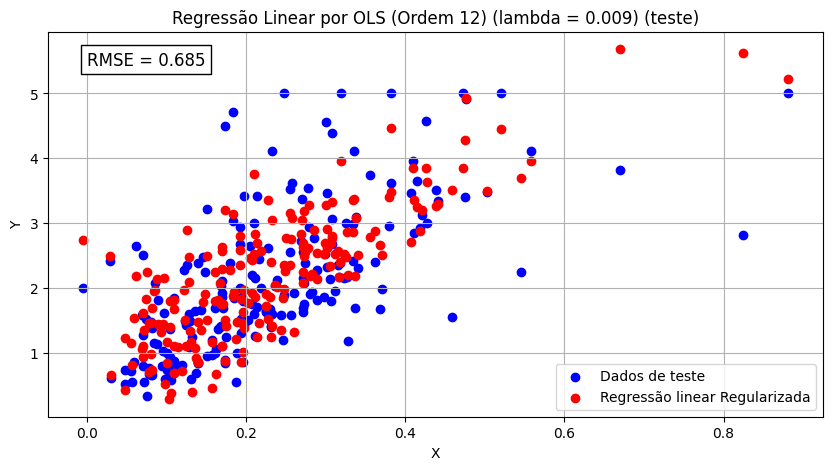

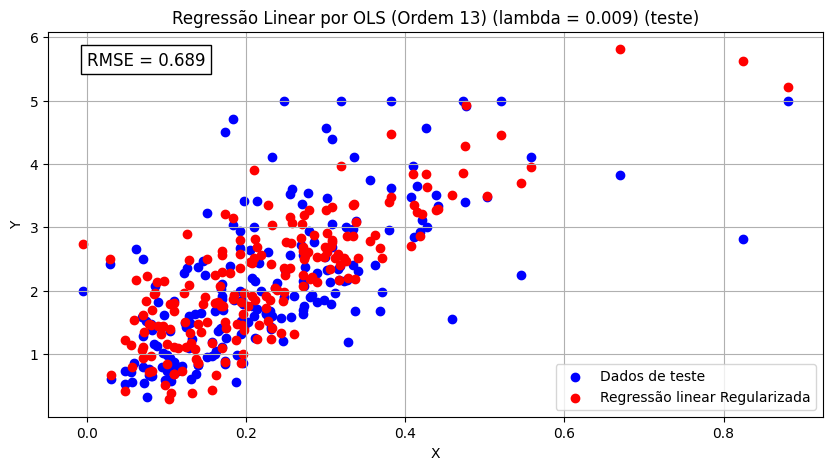

In [70]:
#gráficos do treino
for i in range(order):
    plt.figure(figsize=(10, 5))
    plt.scatter(X_poly[:, 1], Y_train, color='blue', label='Dados de treino')
    plt.scatter(X_poly[:, 1], Y_list[i], color='red', label='Regressão linear Regularizada')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Regressão Linear por OLS (Ordem {i+1}) (Lambda = {LAMBDA}) (treino)")
    plt.text(0.05, 0.95, f"RMSE = {rmse_list[i]:.3f}", transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    plt.grid(True)
    plt.legend()
    plt.show()

#gráficos do teste
for i in range(order):
    X_poly_test = X_test.copy()
    X_poly_test = nonLinearTrans(X_poly_test, i+1) #aplicando a tranformação polinomial
    X_poly_test = (X_poly_test - min_list[i])/(max_list[i] - min_list[i]) #normalizando na mesma escala de treino
    X_poly_test = np.concatenate((np.ones((X_poly_test.shape[0], 1)), X_poly_test), axis=1)

    Y_test_pred = X_poly_test @ W_list[i]
    Y_test_pred = standardRev(Y_test_pred, means, stds) #desnormalizando para calcular o RMSE na mesma escala
    rmse = np.sqrt(np.mean((Y_test - Y_test_pred) ** 2))

    plt.figure(figsize=(10, 5))
    plt.scatter(X_poly_test[:, 1], Y_test, color='blue', label='Dados de teste')
    plt.scatter(X_poly_test[:, 1], Y_test_pred, color='red', label='Regressão linear Regularizada')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Regressão Linear por OLS (Ordem {i+1}) (lambda = {LAMBDA}) (teste)")
    plt.text(0.05, 0.95, f"RMSE = {rmse:.3f}", transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', edgecolor='black'))
    plt.grid(True)
    plt.legend()
    plt.show()